In [56]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import warnings
import logging
from sklearn.model_selection import train_test_split

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.10.0


In [57]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [58]:
x_train = np.load('../training_dataset_homework2/x_train.npy')
y_train = np.load('../training_dataset_homework2/y_train.npy')

In [59]:
x_train.shape, y_train.shape

((2429, 36, 6), (2429,))

In [60]:
x_train[0]

array([[ 1.7597e+01,  8.1713e+00, -1.7842e+00, -1.9706e+01, -9.7135e+00,
        -6.1887e+01],
       [ 2.2974e-01, -5.8956e+00,  1.6837e+01,  5.0390e+00,  2.4332e+00,
         5.8914e+01],
       [-2.9654e+01, -2.1296e+01,  2.9103e+01, -4.7503e-01,  7.5391e+01,
         1.0665e+01],
       [-5.9210e+01, -2.9565e+01,  1.7971e+01, -4.5606e+01,  1.9412e+01,
        -4.3014e+01],
       [-7.2064e+01, -2.5855e+01,  4.6536e-01, -5.9151e+01, -2.9105e+01,
        -1.1913e+01],
       [-5.8355e+01, -1.2052e+01, -3.7655e+00, -1.5372e+01,  4.3188e+01,
         1.3452e+01],
       [-2.4086e+01,  4.3008e+00,  1.3528e+00,  1.8384e+01,  1.7627e+01,
        -6.4709e+01],
       [ 9.5313e+00,  1.4598e+01,  3.4580e+00,  1.6364e+00, -2.7640e+00,
        -3.8644e+01],
       [ 1.9020e+01,  1.4387e+01, -2.0542e+00, -1.9377e+01,  3.0842e+01,
         1.2618e+02],
       [-3.3500e+00,  6.0219e+00, -1.0826e+01, -1.1767e+00,  9.8274e+00,
         2.6656e+00],
       [-4.0648e+01, -2.9042e+00, -1.3918e+01,  3.

In [61]:
x_train, x_test, y_train, y_test = train_test_split(
    x_train, y_train, random_state=seed, test_size=.1
)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2186, 36, 6), (2186,), (243, 36, 6), (243,))

In [62]:
label_mapping = {
    "Wish": 0,
    "Another": 1,
    "Comfortably": 2,
    "Money": 3,
    "Breathe":4,
    "Time":5,
    "Brain":6,
    "Echoes":7,
    "Wearing":8,
    "Sorrow":9,
    "Hey":10,
    "Shine":11
}

In [63]:
# Convert the sparse labels to categorical values
y_train_categorical = tfk.utils.to_categorical(y_train)
y_test_categorical = tfk.utils.to_categorical(y_test)
x_train.shape, y_train_categorical.shape, x_test.shape, y_test_categorical.shape

((2186, 36, 6), (2186, 12), (243, 36, 6), (243, 12))

In [64]:
input_shape = x_train.shape[1:]
classes = y_train_categorical.shape[-1]
batch_size = 64
epochs = 200

In [65]:
def build_LSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    lstm = tfkl.LSTM(128, return_sequences=True)(input_layer)
    lstm = tfkl.LSTM(128)(lstm)
    dropout = tfkl.Dropout(.5, seed=seed)(lstm)

    # Classifier
    classifier = tfkl.Dense(64, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [66]:
model = build_LSTM_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 lstm_2 (LSTM)               (None, 36, 128)           69120     
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 12)                780       
                                                                 
Total params: 209,740
Trainable params: 209,740
Non-trainable

In [67]:
# Train the model
history = model.fit(
    x = x_train,
    y = y_train_categorical,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200


2022-12-12 11:18:56.113904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 11:18:56.568821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 11:18:56.876940: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 11:18:57.509981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 11:18:57.931386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - ETA: 0s - loss: 2.0697 - accuracy: 0.3330

2022-12-12 11:19:04.010217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 11:19:04.175501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 11:19:04.396241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 12s 227ms/step - loss: 2.0697 - accuracy: 0.3330 - val_loss: 1.6713 - val_accuracy: 0.4886 - lr: 0.0010
Epoch 2/200
31/31 [==============================] - 4s 144ms/step - loss: 1.6189 - accuracy: 0.4626 - val_loss: 1.3671 - val_accuracy: 0.5342 - lr: 0.0010
Epoch 3/200
31/31 [==============================] - 5s 150ms/step - loss: 1.3606 - accuracy: 0.5221 - val_loss: 1.2056 - val_accuracy: 0.6027 - lr: 0.0010
Epoch 4/200
31/31 [==============================] - 4s 139ms/step - loss: 1.2130 - accuracy: 0.5821 - val_loss: 1.1339 - val_accuracy: 0.6301 - lr: 0.0010
Epoch 5/200
31/31 [==============================] - 4s 139ms/step - loss: 1.0653 - accuracy: 0.6385 - val_loss: 1.1030 - val_accuracy: 0.6575 - lr: 0.0010
Epoch 6/200
31/31 [==============================] - 4s 139ms/step - loss: 1.0187 - accuracy: 0.6457 - val_loss: 1.0979 - val_accuracy: 0.6347 - lr: 0.0010
Epoch 7/200
31/31 [==============================] - 4s 138ms/step - loss: 

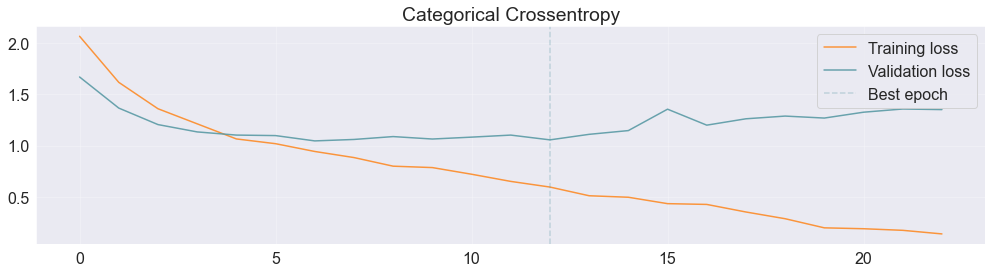

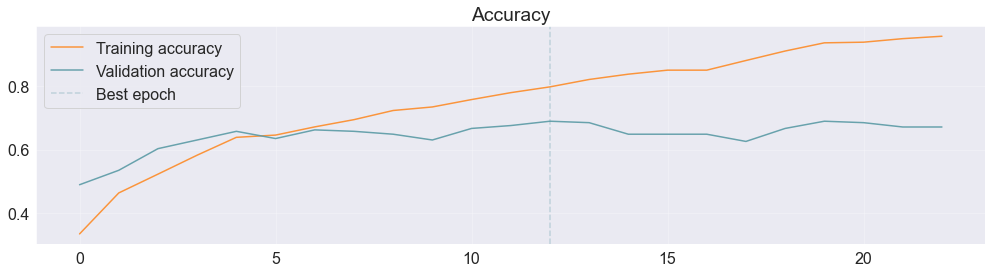

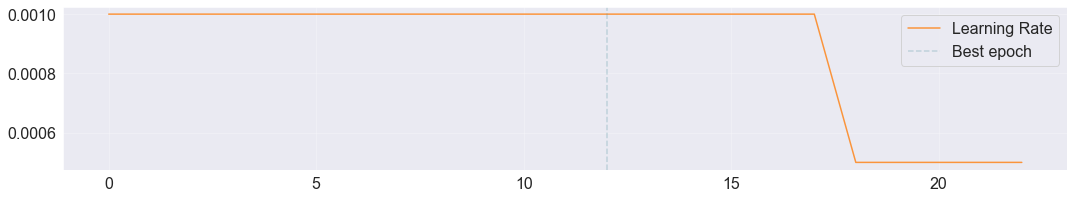

In [68]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [69]:
model.save('federico_01')

INFO:tensorflow:Assets written to: federico_01/assets


INFO:tensorflow:Assets written to: federico_01/assets


In [70]:
predictions = model.predict(x_test)
predictions.shape

2022-12-12 11:21:12.461764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 11:21:12.606724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 11:21:12.844299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 2s 95ms/step


(243, 12)

Accuracy: 0.6996
Precision: 0.54
Recall: 0.523
F1: 0.5124


/Users/federicobono/opt/anaconda3/envs/DeepLearning/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


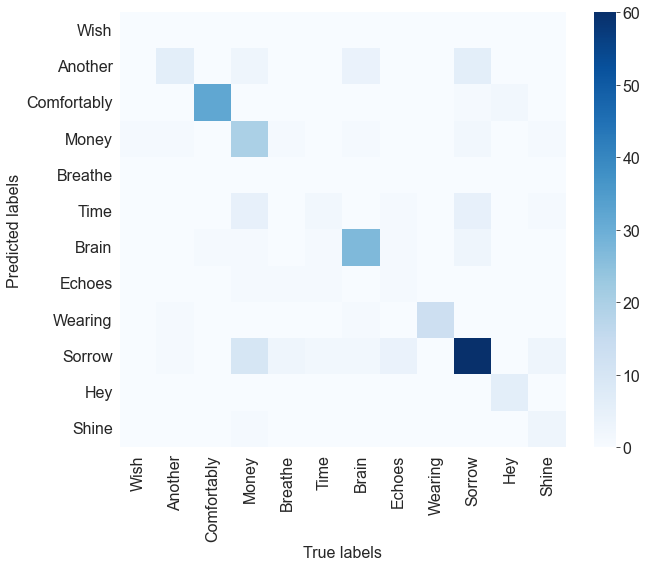

In [71]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test_categorical, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test_categorical, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test_categorical, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test_categorical, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test_categorical, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()